In [32]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import timeit
import math
import random
import requests

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

import scipy.stats as stats 

import shapefile as sf
from matplotlib.patches import Polygon
import mpld3
from matplotlib.collections import PatchCollection
import colormaps as cmaps

import smopy


In [189]:
def classification_stats(model, X_test, y_test):
    predicted = model.predict(X_test)
    probabilities = model.predict_proba(X_test)
    classes = [int(v) for v in list(set(y_test))]
    
    # Get Accuracy and ROC AUC results for each class individually
    start = 0
    if probabilities.shape[1] == 2:
        start = 1
    for i in range(start, probabilities.shape[1]):
        probs = probabilities[:,i]
        current_class = classes[i]
        y_test_i = [1 if current_class == int(v) else 0 for v in y_test]
        predicted_i = [1 if current_class == int(v) else 0 for v in predicted]
        print('Class {}'.format(current_class))
        print('Accuracy: {:0.2f}'.format(sklearn.metrics.accuracy_score(y_test_i, predicted_i)))
        print('ROC AUC Score: {:0.2f}'.format(sklearn.metrics.roc_auc_score(y_test_i, probs)))
        print(' ')
        
    print('Confusion Matrix')

    # Print out confusion matrix legend  if only 2 classes
    if len(classes) == 2:
        print('True Negative (Guess 0, Actual 0)  | False Positive (Guess 1, Actual 0)')
        print('-----------------------------------------------------------------------')
        print('False Negative (Guess 0, Actual 1) |  True Positive (Guess 1, Actual 1)')
        print()

    print(sklearn.metrics.confusion_matrix(y_test, predicted))
    print('')
    print('Classification Report')
    print(sklearn.metrics.classification_report(y_test, predicted))

- Read in the information from the Historic Secured Property Tax Rolls. 
- We only care about R-2 properties
    - Apartments (Code: A, DA, DD, OA, TIA, etc.)
    - Condominiums (Code: Z, ZBM)
    - Residential hotels (Code: RH)
    - All required to have three or more units

First question, how do we extract the R-2 properties from the data set of properties? 
- Can set limits on UNITS
- Can set limits on Property Codes

In [4]:
property_roll = pd.read_csv('challenge_datasets/Historic_Secured_Property_Tax_Rolls.csv')

/Users/kschles/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Note that this only has information through the middle of 2014. There is additional information from 2014-2016 available as .xlsx files on line (http://sfassessor.org/about-us/property-data-0). It's in a slightly different format, so I'm not going to worry about joining them right now. 

In [11]:
# Multi-family residential codes: 
mfc = ['A', 'CO', 'DA', 'DD', 'DF', 'F', 'FA', 'F2', 'OA', 'TIA', 'TIF', 'XV', 'AC', '']
# Condominimum residential codes: 
cc = ['Z', 'ZBM', 'LZ', 'LZBM', 'IZ', 'GZ', 'OZ', 'BZ']
# Residential Hotel codes 
rhc = ['RH']

# R2 codes 
r2_codes = mfc + cc + rhc

The prompt says to expect about 21,000 R-2 properties in total. I'm finding about 19,000 in a given year, so I'd say that's about right. 

2014 shows many fewer than the rest. Perhaps this is a function of only going through June 30, 2014? Either way, I won't sweat it for now.

In [49]:
print 'Year', 'Number of R-2 on Rolls'
for i in xrange(pr['Closed Roll Fiscal Year'].astype(int).min(), pr['Closed Roll Fiscal Year'].astype(int).max() + 1):
    r2_index_yearly = np.where((property_roll['Property Class Code'].isin(r2_codes)==True) 
                 & (property_roll['Closed Roll Fiscal Year']==i)
                 & (property_roll['Number of Units']>=3))[0]
    print i, len(r2_index_yearly)

Year Number of R-2 on Rolls
2007 19258
2008 19185
2009 19140
2010 19071
2011 18902
2012 18965
2013 18934
2014 9007


Extract all R-2 properties for all years

In [14]:
r2_index = np.where((property_roll['Property Class Code'].isin(r2_codes)==True) 
             & (property_roll['Number of Units']>=3))[0]
print 'Total Number of R-2 properties, all years: ',len(r2_index)

Total Number of R-2 properties, all years:  142462


In [16]:
pr = property_roll.loc[r2_index]

pr.reset_index(drop=True, inplace=True)

In [17]:
pr['year'] = pr['Closed Roll Fiscal Year']

Now I have a list of ~all of the R-2 buildings in a given year. I want to match this up with complaint and violation data to get a better picture of the problems around SF

### HIS Violations

First I'll read in the reported violations from HIS: 

- You can import them straight from the OpenDataSF system, so updating is easier. 
- For now, I'm just using the static versions

In [22]:
#url="https://data.sfgov.org/resource/jfcn-py3d.json"
#s=requests.get(url).content
#c=pd.read_json(s)

In [33]:
his_violations = pd.read_csv('challenge_datasets/Notices_of_Violation_issued_by_the_Department_of_Building_Inspection.csv')

The website tells me the following about this data set: 

The data should be sorted on the Complaint Number field and the Item Sequence Number field. The user should be able to link this file with the Building Complaints dataset (https://data.sfgov.org/d/gm2e-bten) to get a more accurate picture of the violations.

Inspection suggests that for each individual complaint number, there can be multiple violations, each associated with a different Item Sequence Number. 

In [50]:
print 'Violations Date Range: ', his_violations['Date Filed'].min(), '-', his_violations['Date Filed'].max()

Violations Date Range:  01/02/1997 - 12/31/2015


In [51]:
his_violations['Date Filed'] = pd.to_datetime(his_violations['Date Filed'], format="%m/%d/%Y", utc=False)

We can also match this data set up with the property roll using Block and Lot information, Address, and/or Location

In [34]:
his_violations['Block and Lot Number'] = his_violations['Block'].str.cat(his_violations['Lot'])

Need to trim down the violations and PR rolls to cover the same date range (2007-2014) 

In [59]:
min_date = '01/01/' + pr['year'].astype(int).min().astype(str)
max_date = '01/01/' + str(pr['year'].astype(int).max() + 1)

01/01/2007 01/01/2015


In [61]:
dindex = np.where((his_violations['Date Filed'] >= min_date) & (his_violations['Date Filed'] < max_date))[0]

his_violations['year'] = pd.to_datetime(his_violations['Date Filed'], format="%m/%d/%Y", utc=False).dt.year

his_vtrimmed = his_violations.loc[dindex]
his_vtrimmed.reset_index(drop=True, inplace=True)

Now we can merge the two data sets. This will give me a sense of how many violations are related to R-2 properties, rather than others. 

In [60]:
pr_viol = pd.merge(his_vtrimmed, pr, how='inner', on=['Block and Lot Number', 'year'])

In [63]:
print 'Fraction of violations that are on R-2 Properties: ', float(len(pr_viol)) / float(len(his_vtrimmed))

Fraction of violations that are on R-2 Properties:  0.645557428365


That lists that there are 80430 violations on R-2 properties between the years of 2007 and 2014. There are 124590 violations overall. 

Approximately 65% of all violations are on R-2 properties. Note that individual properties may have multiple violations however. 

### HIS Complaints

Let's read in the list of HIS complaints. 

As with the HIS violations, this can be accessed directly from the OpenDataSF system, but I'm going with the static ones for right now.

In [64]:
#url="https://data.sfgov.org/resource/frbs-hx9j.json"
#s=requests.get(url).content
#c=pd.read_json(s)

In [69]:
his_complaints = pd.read_csv('challenge_datasets/Building_Complaints.csv')

The documentation on the data set states that: 

Routine and non-routine inspections from the housing division are tracked using complaints only if violations are found during the inspections. The NOVTYPE field can be used to determine the source of the complaint.

Note that each complaint can be associated with multiple violations in the violation list. 

The complaints also cover a different date range than the violations and the property rolls

We can also match this data set up with the property roll using Block and Lot information, Address, and/or Location

In [71]:
print 'Violations Date Range: ', his_complaints['Date Filed'].min(), '-', his_complaints['Date Filed'].max()

Violations Date Range:  01/01/1994 - 12/31/2015


In [72]:
his_complaints['Block and Lot Number'] = his_complaints['Block'].str.cat(his_complaints['Lot'])

In [79]:
his_complaints['Date Filed'] = pd.to_datetime(his_complaints['Date Filed'], format="%m/%d/%Y", utc=False)

Need to trim down the complaints and PR rolls to cover the same date range (2007-2014) 

In [80]:
dindex = np.where((his_complaints['Date Filed'] >= min_date) & (his_complaints['Date Filed'] < max_date))[0]

his_complaints['year'] = pd.to_datetime(his_complaints['Date Filed'], format="%m/%d/%Y", utc=False).dt.year

his_ctrimmed = his_complaints.loc[dindex]
his_ctrimmed.reset_index(drop=True, inplace=True)

Now I want to join this with the property rolls to get a better idea of the complaints on R-2 properties. 

In [83]:
pr_comp = pd.merge(his_ctrimmed, pr, how='inner', on=['Block and Lot Number', 'year'])

In [84]:
print 'Fraction of complaints that are on R-2 Properties: ', float(len(pr_comp)) / float(len(his_ctrimmed))

Fraction of complaints that are on R-2 Properties:  0.430372342331


Approximately 43% of all complaints are on R-2 properties. Each of these complaints can be associated with multiple violations (hence the higher fraction when looking at the Violation information)

In [87]:
print 'NOV Type for R-2 Inspection', 'Number of Complaints'
print pr_comp['NOV Type'].value_counts()

NOV Type for R-2 Inspection Number of Complaints
routine                 11841
complaint                5679
other                     189
ca task force              42
hotel room-room insp        4
Name: NOV Type, dtype: int64


When we consider what triggered the inspection(e.g., NOV Type) of an R-2 property, we find:  
- 11841 R-2s with complaint/violations associated with Routine inspections
- 5679 R-2s with complaint/violations assoicated with resident complaint.

We don't know how many complaints about buildings and building inspections happen overall. 

For the future, can integrate the SF 311 Cases to estimate the number of complaints received vs. those that result in a violation. 
- Items referred to the DBI Housing Inspection Queue. 
- Can query this to identify number of complaints per year. 
- Currently spot-checked it. Found that there are around 850 complaints per year referred to HIS and dealing with Residential Building Requests. 
- We have HIS/PR data for 8 years. Extrapolating, we expect 850 * 8 = 6800 complaints overall. 
- (5679 / 6800) = 0.8351, suggesting that around 84% of all complaints result in a violation! This is likely an overestimate, as it's unclear if all resident complaints referred to DBI/HIS come through this channel. 

We can also try to estimate the total number of Routine R-2 inspections. 

We know that there are: 
- ~19,000 R-2 properties in total 
- For Routine inspections, each gets inspected at least once every five years. 
- Our current data set ranges from 2007 to 2015, a period of over 8 years. 
- Neglecting complaint, repeat inspections, etc. this results in a minimum of 19,0000 * (8 / 5) = 30400 inspections of R-2 properties 
- (11841 / 30400) = 0.3895, suggesting that around 40% of all routine inspections result in a violation.

### Additional metrics

I want to know additional information like: 
- number of violations per R-2 property?
    - Mean: 5.35 +- 4.1
    - Min: 1
    - Max: 105 (!) 
- Does the number of violations relate to number of units? 


In [236]:
viol_per_compl_1 = pr_viol[['Complaint Number', 'Item Sequence Number']].groupby('Complaint Number', as_index=False).count()

In [237]:
viol_per_compl_1.rename(columns = {'Item Sequence Number' : 'Number of Violations'}, inplace=True)

In [238]:
viol_per_compl = pd.merge(viol_per_compl_1, pr_comp[['Complaint Number', 'NOV Type']], how='left', on='Complaint Number')

In [239]:
viol_combo_vers = pr_viol.groupby('Complaint Number', as_index=False).agg('first')

In [240]:
pr_viol_combo = pd.merge(viol_combo_vers, viol_per_compl, how='left', on='Complaint Number')

In [241]:
print "Statistics on Number of Violations per R-2 Property :"
pr_viol_combo['Number of Violations'].describe()

Statistics on Number of Violations per R-2 Property :


count    15082.000000
mean         5.346241
std          4.073702
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        105.000000
Name: Number of Violations, dtype: float64

In [242]:
viol_per_unit = pr_viol_combo['Number of Violations'].astype(float) / pr_viol_combo['Number of Units'].astype(float)

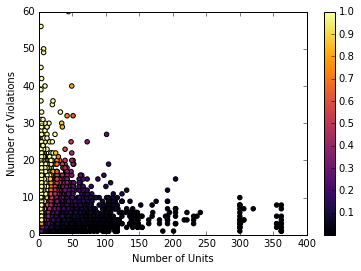

In [243]:
plt.scatter(pr_viol_combo['Number of Units'], pr_viol_combo['Number of Violations'], c=viol_per_unit, cmap='inferno', 
           vmax=1)
plt.colorbar()
plt.xlim(0,400)
plt.ylim(0,60)
plt.xlabel('Number of Units')
plt.ylabel('Number of Violations')

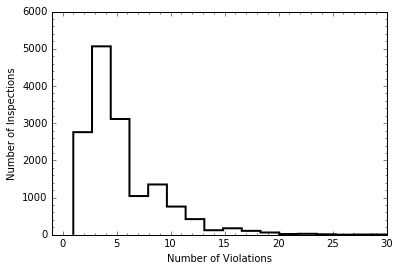

In [244]:
a = plt.hist(viol_per_compl['Number of Violations'], bins=60, histtype='step', lw=2, color='k')
plt.xlim(-1,30)
plt.xlabel('Number of Violations')
plt.ylabel('Number of Inspections')
plt.minorticks_on()

plt.savefig('output_figs/violations_per_inspection.jpg', bbox_inches='tight')

Below, we see that there are slighly more violations found per complaint than by routine inspection, but it is not statistically significant.

In [245]:
for i in ['routine', 'complaint']: 
    temporary = pr_viol_combo.loc[np.where(pr_viol_combo['NOV Type']==i)[0], 'Number of Violations']
    print i,' Violation Statistics:'
    print temporary.describe()

routine  Violation Statistics:
count    2764.000000
mean        4.138205
std         3.095021
min         1.000000
25%         1.000000
50%         4.000000
75%         6.000000
max        26.000000
Name: Number of Violations, dtype: float64
complaint  Violation Statistics:
count    1233.000000
mean        4.685320
std         4.187751
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        33.000000
Name: Number of Violations, dtype: float64


- Is there variation in the mean number of violations over time?

Below, we see that there isn't a huge amount of variation in the number of violations found in a property (provided it has one violation) year by year. However, there are a few years (such as 2014) which have some significant outliers! 

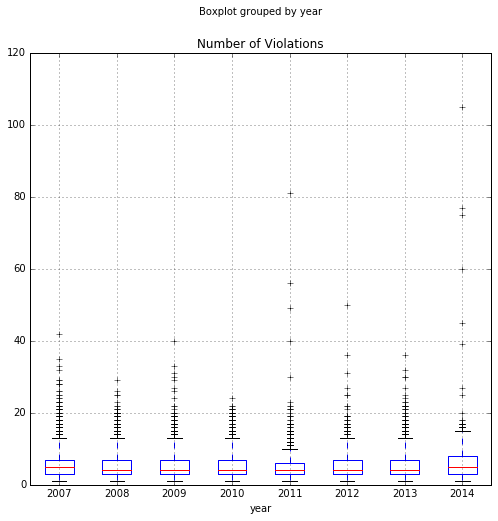

In [246]:
pr_viol_combo.boxplot(column='Number of Violations',by='year',figsize=(8,8))
plt.savefig('output_figs/violations_year.jpg', bbox_inches='tight')

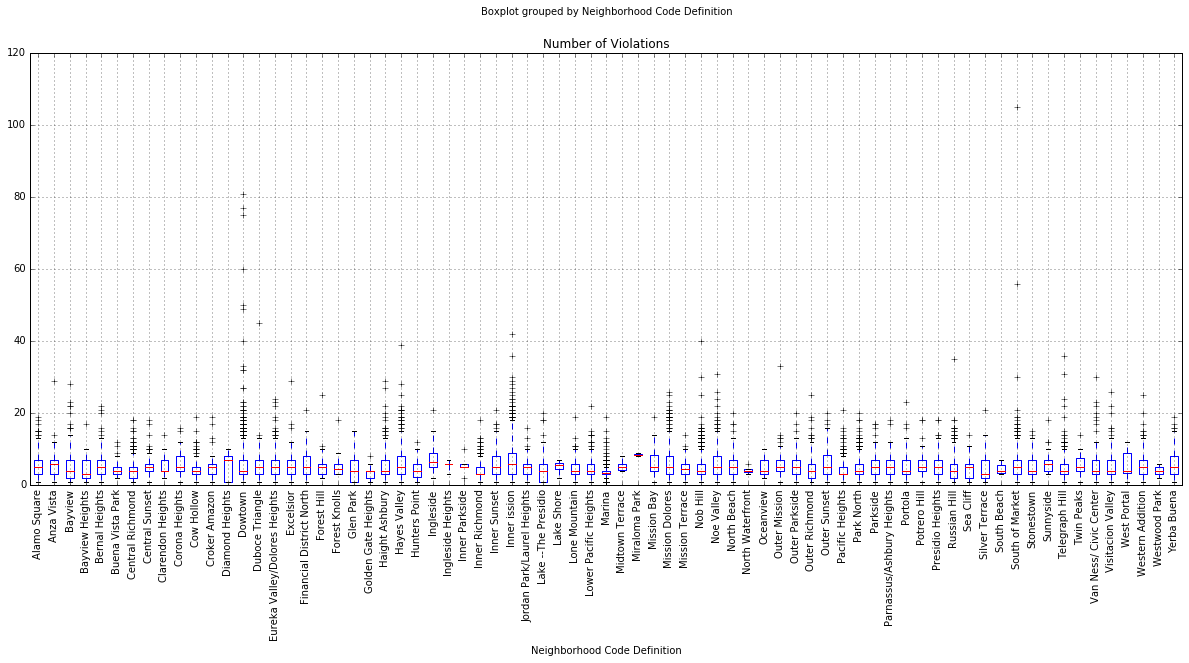

In [173]:
pr_viol_combo.boxplot(column='Number of Violations',by='Neighborhood Code Definition',figsize=(20,8), rot=90)
plt.savefig('output_figs/violations_nhood.jpg', bbox_inches='tight')

I know that there are 19 HIS Districts. However, I only have information about the districts associated with the Board of Supervisors at this time. There is a map of the HIS districts online, and I've pulled the kml files from it.

I'm not going to worry too much about the districting discrepancies for right now, but it is definitely something to handle in the future. 

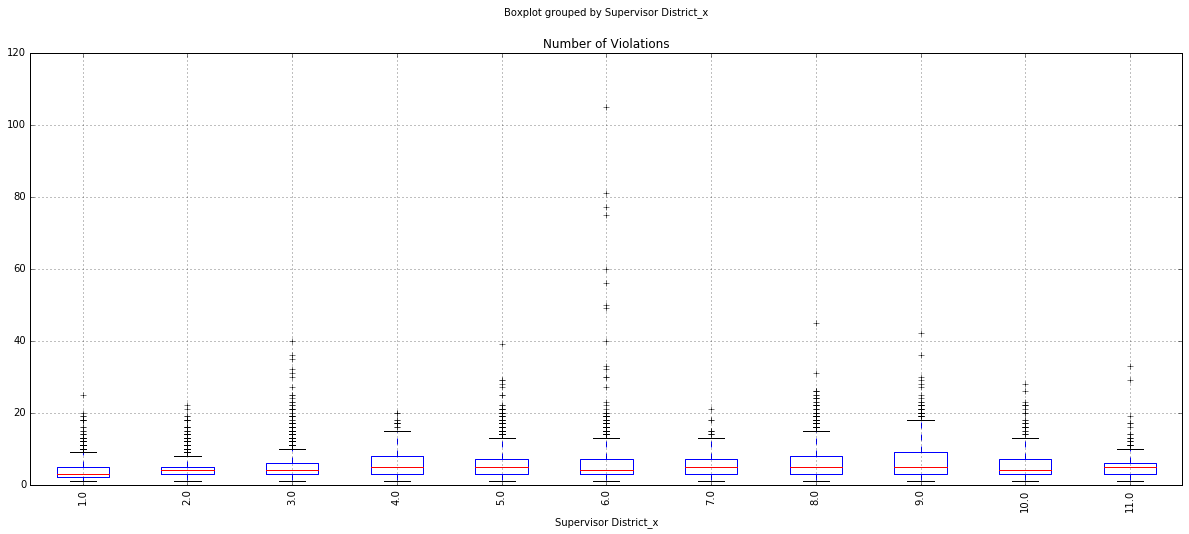

In [247]:
pr_viol_combo.boxplot(column='Number of Violations',by='Supervisor District_x',figsize=(20,8), rot=90)
fig.savefig('output_figs/violations_supdistrict.jpg', bbox_inches='tight')

In [248]:
pr_viol_combo['lat'] = pr_viol_combo['Location_x'].str.split(',').str[0].str.replace('(', '').astype(float)
pr_viol_combo['lon'] = pr_viol_combo['Location_x'].str.split(',').str[1].str.replace(')', '').astype(float)

Read in Shapefiles

In [175]:
n_reader = sf.Reader('datasets/neighborhoods/geo_export_565bd83a-4c34-4e72-87e1-899e28098e15.shp')
n_records = pd.DataFrame(n_reader.records())
n_shapes = n_reader.shapes()

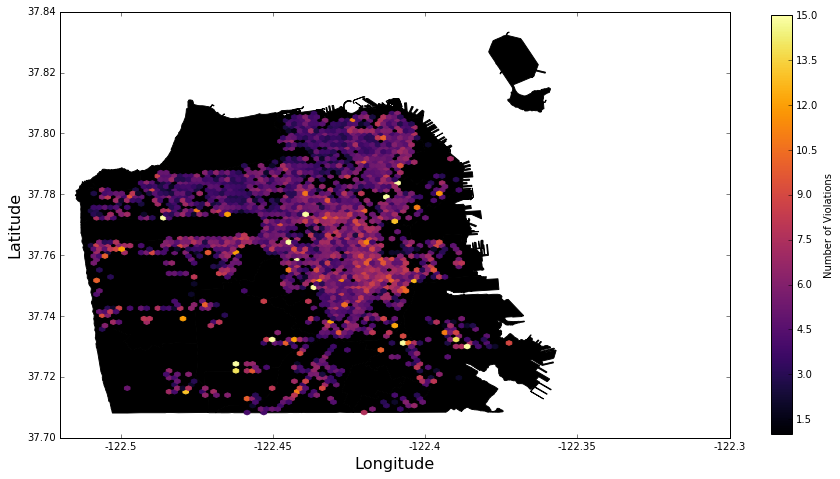

In [176]:
fig,ax = plt.subplots(1,1, figsize=(15,15))

patches1 = []
for i in range(0,len(n_shapes)): 
    if len(n_shapes[i].parts)>1: 
        temp = n_shapes[i].parts
        for j in range(1, len(temp)): 
            barf = pd.DataFrame(n_shapes[i].points[temp[j-1]:temp[j]])
            poly = plt.Polygon(barf[[0,1]], fc='k', ec='k', alpha=1.0, lw=0.9, zorder=2)
            patches1.append(poly)
            plt.gca().add_patch(poly)    
            if (j == len(temp)-1): 
                barf = pd.DataFrame(n_shapes[i].points[temp[j]:])
                poly = plt.Polygon(barf[[0,1]], fc='k', ec='k', alpha=1.0, lw=0.9, zorder=2)
                patches1.append(poly)
                plt.gca().add_patch(poly)                    
    else: 
        barf = pd.DataFrame(n_shapes[i].points)
        poly = plt.Polygon(barf[[0,1]], fc='k', ec='k', alpha=1.0, lw=0.9, zorder=2)
        patches1.append(poly)
        plt.gca().add_patch(poly)
    
    
plt.axis('scaled')
plt.xlim(-122.52, -122.34)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)

# Set the X tick labels so they're useful! 
x_vals = [-122.5, -122.45, -122.4, -122.35, -122.3]
labels = ['-122.5', '-122.45', '-122.4','-122.35', '-122.3']
ax.set_xticks(x_vals)
ax.set_xticklabels(labels)


plt.hexbin(pr_viol_combo['lon'], pr_viol_combo['lat'], gridsize=75, cmap='inferno', 
           C=pr_viol_combo['Number of Violations'], 
           reduce_C_function = np.mean, zorder=3, vmax=15)
plt.colorbar(shrink=0.5, label='Number of Violations')

fig.savefig('output_figs/violations_map.jpg', bbox_inches='tight')

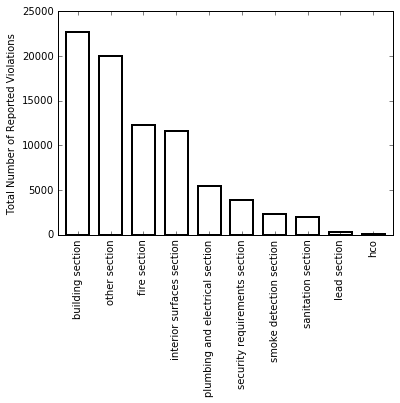

In [301]:
pr_viol['NOV Category Description'].value_counts().plot(kind='bar',ls='-', fc='None', lw=2, 
                                                               zorder=1, position=0.5, width=0.7)
plt.ylabel('Total Number of Reported Violations')
plt.savefig('output_figs/violations_types.jpg', bbox_inches='tight')

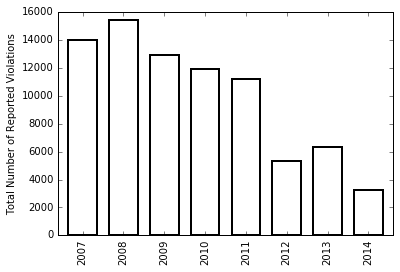

In [302]:
pr_viol['year'].value_counts().sort_index().plot(kind='bar',ls='-', fc='None', lw=2, 
                                                               zorder=1, position=0.5, width=0.7)
plt.ylabel('Total Number of Reported Violations')
plt.savefig('output_figs/violations_types.jpg', bbox_inches='tight')

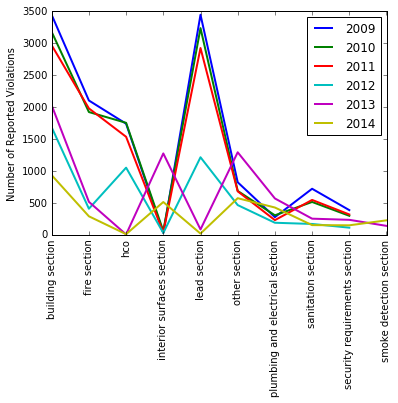

In [305]:
for i in range(2009,2015): 
    pr_viol.loc[np.where(pr_viol['year'] == i)[0], 
                  'NOV Category Description'].value_counts().sort_index().plot(kind='line',ls='-', lw=2, 
                                                                               label=i, rot = 90)

plt.ylabel('Number of Reported Violations')
plt.legend()

### Prepare data for ML modeling

Remember that this is a biased sample, as in it only includes properties where there have been violations! To get a true sense of the city, I need to match all R-2 properties in a given year with the violation information for that same year. 

Below, I use group by to get a list of all the R-2 properties and the number of complaints associated in a given year. I can combine this with other info to do my modeling. 

In [331]:
pr_all = pd.merge(pr, his_ctrimmed, how='left', on=['Block and Lot Number', 'year'])

In [332]:
viol_per_compl_all = pr_all[['Block and Lot Number', 'year', 'Complaint Number']].groupby(['Block and Lot Number', 'year'], as_index=False).count()

In [333]:
viol_per_compl_all.rename(columns = {'Complaint Number' : 'Number of Complaints'}, inplace=True)

In [334]:
complaints_all = pd.merge(viol_per_compl_all, pr_all, how='left', on=['Block and Lot Number', 'year'])

In [335]:
complaints_all['comp_binary'] = 0
complaints_all.loc[np.where(complaints_all['Number of Complaints'] > 0)[0], 'comp_binary'] = 1

In [336]:
complaints_all = pd.get_dummies(complaints_all, columns = ['NOV Type'])

In [338]:
complaints_all['lat'] = complaints_all['Location_x'].str.split(',').str[0].str.replace('(', '').astype(float)
complaints_all['lon'] = complaints_all['Location_x'].str.split(',').str[1].str.replace(')', '').astype(float)

In [395]:
col_choice = ['year', 'Year Property Built', 'Number of Bathrooms', 'Number of Bedrooms',
              'Number of Rooms', 'Number of Stories', 'Number of Units',
              'Lot Depth', 'Lot Frontage', 'Property Area in Square Feet',
              'Basement Area', 'Lot Area', 
              'Tax Rate Area Code', 'Percent of Ownership',
              'Closed Roll Misc Exemption Value',
              'Closed Roll Homeowner Exemption Value', 
              'Closed Roll Assessed Fixtures Value',
              'Closed Roll Assessed Improvement Value',
              'Closed Roll Assessed Land Value',
              'Closed Roll Assessed Personal Prop Value', 'Zipcode of Parcel', 
              'lat', 'lon', 'comp_binary', 'Property Location', 'Neighborhood Code Definition']

#### Train/Test split

- Time is a factor here, so I'll start by selecting everything before 2013 as my training set
- Skewed classes. The number of properties without violations vastly outnumbers the number with violations. 

In [402]:
X2013 = complaints_all.loc[np.where(complaints_all['year']<2013)[0], col_choice].dropna()
X2013.reset_index(drop=True, inplace=True)

# Because skewed classes, need to even them out with undersampling
no_comp = X2013.loc[np.where(X2013['comp_binary']==0)[0]]
no_comp.reset_index(drop=True, inplace=True)
indexing = random.sample(xrange(0, len(no_comp)), len(np.where(X2013['comp_binary']>0)[0]))

no_comp_selected = no_comp.loc[indexing]
yes_comp = X2013.loc[np.where(X2013['comp_binary']==1)[0]]

Xtrain = pd.concat([no_comp_selected, yes_comp], axis=0)
ytrain = Xtrain['comp_binary']

Xtest = complaints_all.loc[np.where(complaints_all['year']>=2013)[0], col_choice].dropna()
ytest = Xtest['comp_binary']

Xtrain.drop('comp_binary', axis=1, inplace=True)
Xtest.drop('comp_binary', axis=1, inplace=True)

Xtrain_orig = Xtrain.copy()
Xtest_orig = Xtest.copy()

Xtrain.drop(['Property Location', 'Neighborhood Code Definition'], axis=1, inplace=True)
Xtest.drop(['Property Location', 'Neighborhood Code Definition'], axis=1, inplace=True)

### Logistic Regression modeling

In [404]:
lr = LogisticRegression(penalty='l2')

In [405]:
clf = lr.fit(Xtrain, ytrain)

Cross Validation. We want to maximize the number of True Positives (properties with violations) and minimize the number of False Positives (properties the model tells you to inspect that don't actually have violations). Thus, I'm using ROC/AUC as my metric here

In [362]:
k = 10
scores = cross_val_score(
    clf,
    Xtrain, ytrain,
    scoring='roc_auc', #recall, f1
    cv=k
)
print('{}-fold Cross-Validation: {:0.2f} +- {:0.2f}'.format(k, scores.mean(), scores.std()))

10-fold Cross-Validation: 0.63 +- 0.12


I'm actually getting a better ROC/AUC score for my testing set than for my training set. That's pretty unusual.

In [406]:
classification_stats(clf, Xtest, ytest)

Class 1
Accuracy: 0.79
ROC AUC Score: 0.71
 
Confusion Matrix
True Negative (Guess 0, Actual 0)  | False Positive (Guess 1, Actual 0)
-----------------------------------------------------------------------
False Negative (Guess 0, Actual 1) |  True Positive (Guess 1, Actual 1)
()
[[20503  3626]
 [ 2620  2333]]

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.85      0.87     24129
          1       0.39      0.47      0.43      4953

avg / total       0.80      0.79      0.79     29082



18: 0.713861


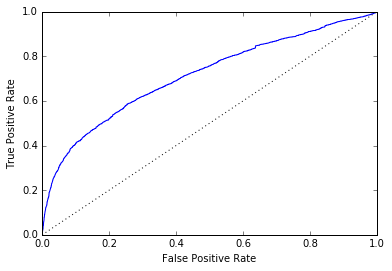

In [407]:
preds = clf.predict_proba(Xtest) # probability that each item is classified as a certain label

 
fpr, tpr, thresholds = sklearn.metrics.roc_curve(ytest, preds[:,1], pos_label=1)
plt.plot(fpr, tpr)

print str(i) + ': %f' %sklearn.metrics.auc(fpr,tpr)

plt.plot([0,1], [0,1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.savefig('output_figs/lr_roc.jpg', bbox_inches='tight')

### Random Forest Classification 

In [408]:
rfc = RandomForestClassifier(n_estimators=5, max_features='auto')

rfmodel = rfc.fit(Xtrain, ytrain)

Don't need to do cross validation for Random Forest; it's built in.

In [409]:
classification_stats(rfmodel, Xtest, ytest)

Class 1
Accuracy: 0.78
ROC AUC Score: 0.70
 
Confusion Matrix
True Negative (Guess 0, Actual 0)  | False Positive (Guess 1, Actual 0)
-----------------------------------------------------------------------
False Negative (Guess 0, Actual 1) |  True Positive (Guess 1, Actual 1)
()
[[20292  3837]
 [ 2551  2402]]

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.84      0.86     24129
          1       0.38      0.48      0.43      4953

avg / total       0.80      0.78      0.79     29082



18: 0.702965


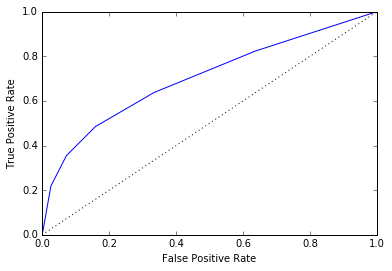

In [410]:
preds = rfmodel.predict_proba(Xtest) # probability that each item is classified as a certain label

 
fpr, tpr, thresholds = sklearn.metrics.roc_curve(ytest, preds[:,1], pos_label=1)
plt.plot(fpr, tpr)

print str(i) + ': %f' %sklearn.metrics.auc(fpr,tpr)

plt.plot([0,1], [0,1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.savefig('output_figs/rf_roc.jpg', bbox_inches='tight')

RF AUC: 0.702965
LR AUC: 0.713861


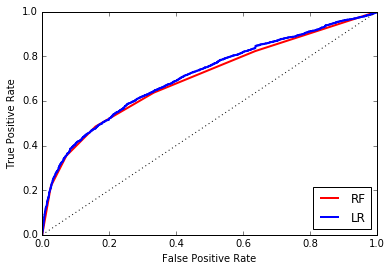

In [411]:
preds_rf = rfmodel.predict_proba(Xtest) # probability that each item is classified as a certain label
preds_lr = clf.predict_proba(Xtest) # probability that each item is classified as a certain label

fpr, tpr, thresholds = sklearn.metrics.roc_curve(ytest, preds_rf[:,1], pos_label=1)
plt.plot(fpr, tpr, 'r-', lw=2, label='RF')
print 'RF AUC: %f' %sklearn.metrics.auc(fpr,tpr)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(ytest, preds_lr[:,1], pos_label=1)
plt.plot(fpr, tpr, 'b-', lw=2, label='LR')
print 'LR AUC: %f' %sklearn.metrics.auc(fpr,tpr)

plt.plot([0,1], [0,1], 'k:')
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.savefig('output_figs/lr_rf_roc.jpg', bbox_inches='tight')

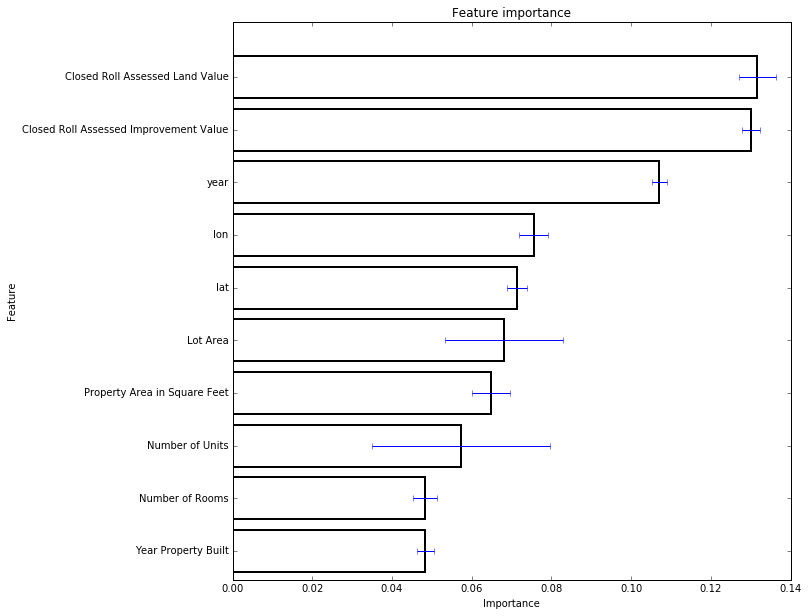

In [412]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
importances = rfmodel.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfmodel.estimators_],
             axis=0)
indices = np.argsort(importances)

fnames = []
for i in indices: 
    fnames.append(col_choice[i])

plt.title('Feature importance')
plt.barh(range(Xtrain.shape[1]), importances[indices],
       color='w', xerr=std[indices], align='center', lw=2)
#plt.xlim(0,0.16)
plt.yticks(range(Xtrain.shape[1]), fnames, rotation=0)
plt.ylim(Xtrain.shape[1] - 10.55,Xtrain.shape[1] + 0.05)
plt.ylabel('Feature')
plt.xlabel('Importance')

plt.savefig('output_figs/rf_features.jpg', bbox_inches='tight')

In [415]:
Xtest_orig['predicted_prob'] = preds[:,1]

Xtest_orig.to_csv('rf_predictions.csv')

### Random Forest Regression Modeling

Ideally, I could also model the number of expected violations per building, to further prioritize which ones to inspect. However, I'm not really able to get this working effectively at the moment. 

Features I want: 
- Previous violations for a property
- Date of last inspection 

In [283]:
col_choice_regress = ['year', 'Year Property Built', 'Number of Bathrooms', 'Number of Bedrooms',
       'Number of Rooms', 'Number of Stories', 'Number of Units',
       'Lot Depth', 'Lot Frontage', 'Property Area in Square Feet',
       'Basement Area', 'Lot Area', 
       'Tax Rate Area Code', 'Percent of Ownership',
       'Closed Roll Misc Exemption Value',
       'Closed Roll Homeowner Exemption Value', 
       'Closed Roll Assessed Fixtures Value',
       'Closed Roll Assessed Improvement Value',
       'Closed Roll Assessed Land Value',
       'Closed Roll Assessed Personal Prop Value', 'Zipcode of Parcel',
       'Supervisor District_x', 'Number of Violations']

In [284]:
pr_viol_combo.corr(method='pearson')['Number of Violations']

Item Sequence Number                        0.048478
Street Number                              -0.005041
Unit                                       -0.007655
Supervisor District_x                       0.136128
Zipcode                                    -0.064260
year                                        0.031446
Closed Roll Fiscal Year                     0.031446
Volume Number                               0.085221
Year Property Built                        -0.038351
Number of Bathrooms                        -0.028043
Number of Bedrooms                         -0.026161
Number of Rooms                            -0.024340
Number of Stories                          -0.015074
Number of Units                            -0.021494
Lot Depth                                  -0.008907
Lot Frontage                                0.003987
Property Area in Square Feet               -0.027623
Basement Area                              -0.022992
Lot Area                                   -0.

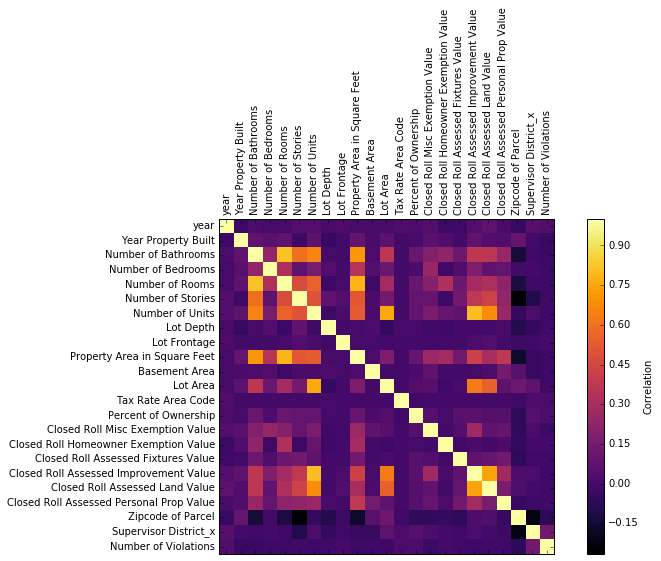

In [285]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

cb = ax.matshow(pr_viol_combo[col_choice_regress].corr(method='pearson'), cmap='inferno')
plt.xticks(range(len(col_choice_regress)), col_choice_regress, rotation=90)
plt.yticks(range(len(col_choice_regress)), col_choice_regress, rotation=0)

plt.colorbar(cb, label='Correlation', ax=ax, fraction=0.046, shrink=1.0)

plt.savefig('output_figs/correlations.jpg', bbox_inches='tight')

In [286]:
pr_viol_clean = pr_viol_combo[col_choice_regress].dropna()
pr_viol_clean.reset_index(drop=True, inplace=True)

In [287]:
pr_viol_clean = pr_viol_clean.dropna()
pr_viol_clean.reset_index(drop=True, inplace=True)

In [288]:
# Train/Test Split 
# Because time is a factor, I will select everything up until 2013 as my training. 
Xtrain = pr_viol_clean.loc[np.where(pr_viol_clean['year']<2013)[0], col_choice_regress]
ytrain = pr_viol_clean.loc[np.where(pr_viol_clean['year']<2013)[0], ['Number of Violations']]

Xtest = pr_viol_clean.loc[np.where(pr_viol_clean['year']>=2013)[0], col_choice_regress]
ytest = pr_viol_clean.loc[np.where(pr_viol_clean['year']>=2013)[0], ['Number of Violations']]

Xtrain.drop('Number of Violations', axis=1, inplace=True)
Xtest.drop('Number of Violations', axis=1, inplace=True)

In [289]:
rfr = RandomForestRegressor(n_estimators=10)

model = rfr.fit(Xtrain, ytrain)

/Users/kschles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


(0, 40)

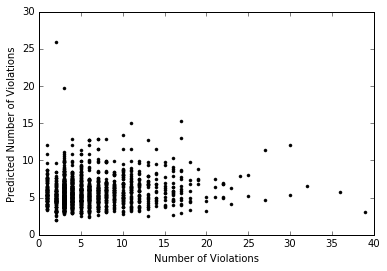

In [290]:
plt.plot(ytest, model.predict(Xtest), 'k.')
plt.xlabel('Number of Violations')
plt.ylabel('Predicted Number of Violations')
plt.xlim(0,40)

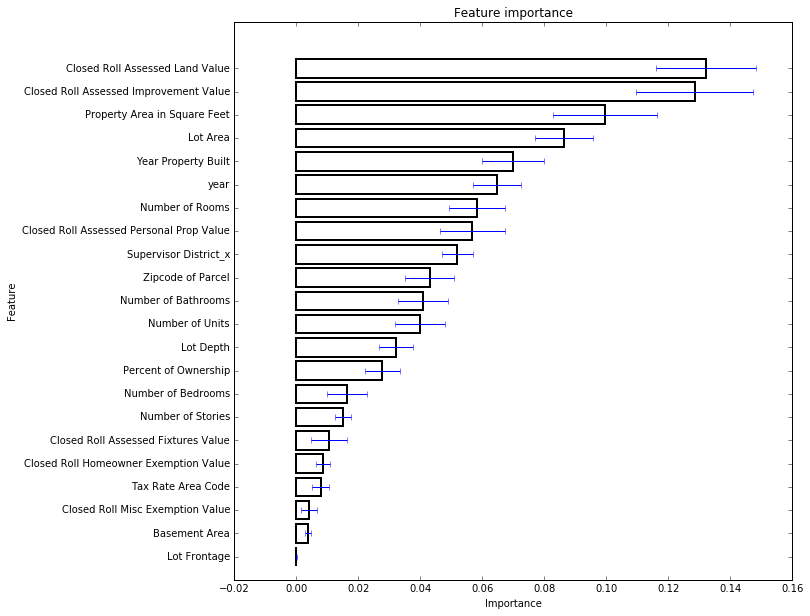

In [291]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)

fnames = []
for i in indices: 
    fnames.append(col_choice_regress[i])

plt.title('Feature importance')
plt.barh(range(Xtrain.shape[1]), importances[indices],
       color='w', xerr=std[indices], align='center', lw=2)
plt.ylim(-1,Xtrain.shape[1] + 1)
#plt.xlim(0,0.16)
plt.yticks(range(Xtrain.shape[1]), fnames, rotation=0)
plt.ylabel('Feature')
plt.xlabel('Importance')


In [292]:
r2 = r2_score(ytest, model.predict(Xtest))
mse = np.mean((ytest['Number of Violations'] - model.predict(Xtest))**2)
print r2, mse

-0.043956633825 36.5314860265


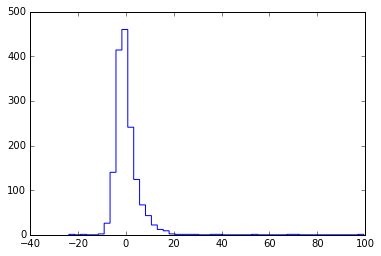

In [293]:
a = plt.hist((np.array(ytest['Number of Violations']) - model.predict(Xtest)), bins=50, histtype='step')

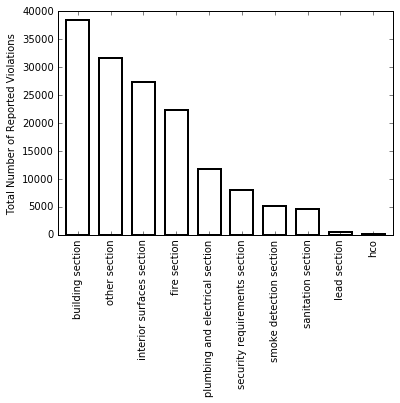

In [304]:
comp_viol['NOV Category Description'].value_counts().plot(kind='bar',ls='-', fc='None', lw=2, 
                                                               zorder=1, position=0.5, width=0.7)
plt.ylabel('Total Number of Reported Violations')

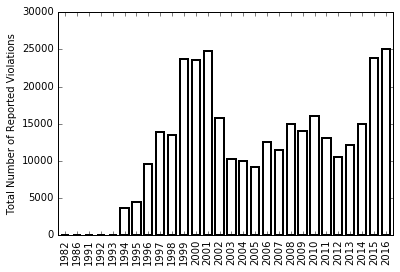

In [327]:
comp_viol['year'].value_counts().sort_index().plot(kind='bar',ls='-', fc='None', lw=2, 
                                                               zorder=1, position=0.5, width=0.7)
plt.ylabel('Total Number of Reported Violations')

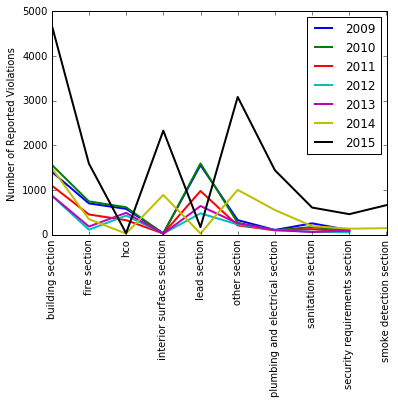

In [325]:
for i in range(2009,2016): 
    comp_viol.loc[np.where(comp_viol['year'] == i)[0], 
                  'NOV Category Description'].value_counts().sort_index().plot(kind='line',ls='-', lw=2, 
                                                                               label=i, rot = 90)

plt.ylabel('Number of Reported Violations')
plt.legend()